# Marketmind - Product Recommendation Engine

This notebook implements as association rule mining model to power a 'Frequently Bought Together" product recommendation system.

In [1]:
# Import libraries
import pandas as pd
import numpy as np

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set visual style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Load the dataset
df = pd.read_csv('../data/processed/silver_sales.csv', parse_dates=['invoice_date'], dtype={
    'quantity': np.int32,
    'year': 'category',
    'month': 'category',
    'invoice': 'object',
    'customer_id': 'object'
})

In [4]:
# Prepare Basket data for Association Rule Mining by grouping items by invoice
basket_data = df.groupby('invoice')['stockcode'].apply(list).reset_index(name='items')

In [5]:
# Encode transaction for Machine Learning
# Convert the basket into one-hot encoded format for the Apriori algorithm
te = TransactionEncoder()
te_ary = te.fit(basket_data['items']).transform(basket_data['items'])
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

In [6]:
# Find frequent Itemsets with 
min_support =0.01
frequent_item_sets = apriori(basket_df,
                             min_support=min_support,
                             use_colnames=True,
                             max_len=3
                            )

frequent_item_sets.sort_values('support', ascending=False, inplace=True)
print(len(frequent_item_sets))
frequent_item_sets.head(10)

1292


,support,itemsets
679,0.134028,(85123A)
676,0.099653,(85099B)
356,0.097879,(22423)
84,0.077894,(21212)
23,0.076345,(20725)
650,0.070124,(84879)
587,0.066802,(47566)
89,0.060831,(21232)
344,0.059907,(22383)
25,0.058732,(20727)


In [7]:
# Generate Association Rules
rules = association_rules(frequent_item_sets,
                         metric='lift',
                         min_threshold=1.0)
rules.sort_values(['confidence', 'lift'], ascending=[False, False], inplace=True)
print(len(rules))
rules.head()

1598


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
158,"(22698, 22699)",(22697),0.020285,0.033800,0.018362,0.905172,26.779857,1.0,0.017676,10.189013,0.982591,0.513986,0.901855,0.724205
736,"(22698, 22423)",(22697),0.013840,0.033800,0.012366,0.893502,26.434578,1.0,0.011898,9.072450,0.975674,0.350567,0.889776,0.629678
1470,"(22745, 22746)",(22748),0.011517,0.018537,0.010218,0.887202,47.862262,1.0,0.010004,8.701051,0.990514,0.515113,0.885071,0.719207
809,"(21080, 21086)",(21094),0.013915,0.024582,0.012116,0.870736,35.421438,1.0,0.011774,7.545941,0.985481,0.459280,0.867478,0.681811
1469,"(22748, 22746)",(22745),0.011841,0.017562,0.010218,0.862869,49.131993,1.0,0.010010,7.164238,0.991386,0.532552,0.860418,0.722331


In [8]:
# Identify the most commercially usefull rules with high confidence and lift
strong_rules = rules[(rules['confidence'] > 0.5) & (rules['lift'] > 2)]
print(len(strong_rules))
for index, row in strong_rules.head(15).iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])
    print(f"Rule: If bought {antecedents}, then also buy {consequents}")
    print(f"  Support: {row['support']:.3f}, Confidence: {row['confidence']:.3f}, Lift: {row['lift']:.3f}\n")

380
Rule: If bought ['22698', '22699'], then also buy ['22697']
  Support: 0.018, Confidence: 0.905, Lift: 26.780

Rule: If bought ['22698', '22423'], then also buy ['22697']
  Support: 0.012, Confidence: 0.894, Lift: 26.435

Rule: If bought ['22745', '22746'], then also buy ['22748']
  Support: 0.010, Confidence: 0.887, Lift: 47.862

Rule: If bought ['21080', '21086'], then also buy ['21094']
  Support: 0.012, Confidence: 0.871, Lift: 35.421

Rule: If bought ['22748', '22746'], then also buy ['22745']
  Support: 0.010, Confidence: 0.863, Lift: 49.132

Rule: If bought ['20723', '22356'], then also buy ['20724']
  Support: 0.012, Confidence: 0.856, Lift: 16.836

Rule: If bought ['22697', '22698'], then also buy ['22699']
  Support: 0.018, Confidence: 0.851, Lift: 23.913

Rule: If bought ['22698', '22423'], then also buy ['22699']
  Support: 0.012, Confidence: 0.847, Lift: 23.797

Rule: If bought ['22746'], then also buy ['22748']
  Support: 0.012, Confidence: 0.840, Lift: 45.339

Rule: 

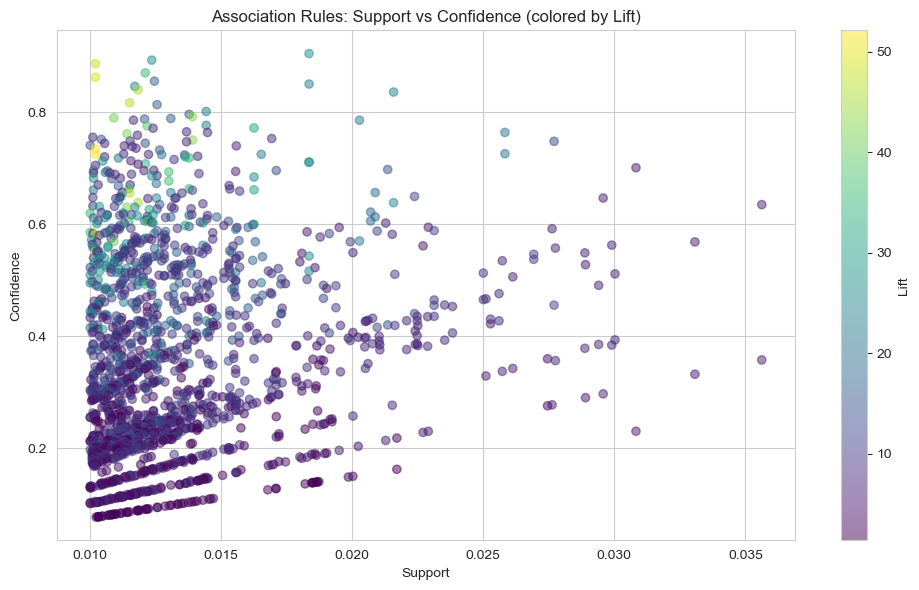

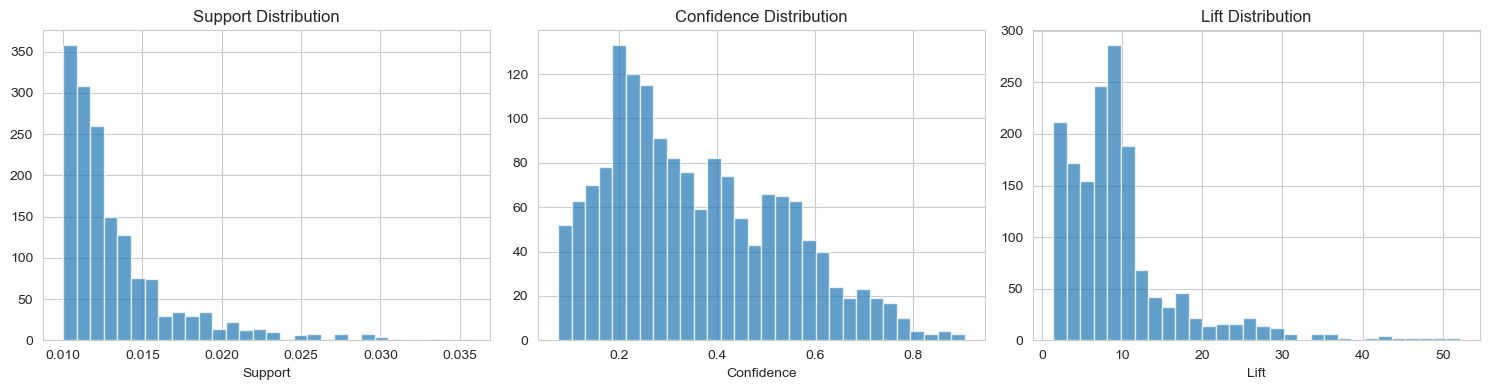

In [11]:
# Create scatter plot of rules
plt.figure(figsize=(10, 6))
plt.scatter(rules['support'], rules['confidence'], alpha=0.5, c=rules['lift'], cmap='viridis')
plt.colorbar(label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs Confidence (colored by Lift)')
plt.tight_layout()
plt.savefig('../img/association_rules_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot distribution of rule metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(rules['support'], bins=30, alpha=0.7)
axes[0].set_title('Support Distribution')
axes[0].set_xlabel('Support')

axes[1].hist(rules['confidence'], bins=30, alpha=0.7)
axes[1].set_title('Confidence Distribution')
axes[1].set_xlabel('Confidence')

axes[2].hist(rules['lift'], bins=30, alpha=0.7)
axes[2].set_title('Lift Distribution')
axes[2].set_xlabel('Lift')

plt.tight_layout()
plt.savefig('../img/rule_metrics_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
def get_recommendations(product_code, rules_df, num_recommendations=5):
    """
    Get product recommendations based on association rules
    
    Parameters:
    product_code (str): The product to get recommendations for
    rules_df (DataFrame): Association rules dataframe
    num_recommendations (int): Number of recommendations to return
    
    Returns:
    list: Recommended product codes
    """
    recommendations = []
    
    # Find rules where the product is in the antecedents
    product_rules = rules_df[
        rules_df['antecedents'].apply(lambda x: product_code in x)
    ].head(num_recommendations)
    
    # Extract recommended products
    for _, row in product_rules.iterrows():
        recommended_products = list(row['consequents'])
        recommendations.extend(recommended_products)
    
    return list(set(recommendations))  # Return unique recommendations

# Test with a sample product
sample_product = '85123A'  # Replace with a product from your top sellers
if sample_product in df['stockcode'].values:
    recommendations = get_recommendations(sample_product, rules)
    product_description = df[df['stockcode'] == sample_product]['description'].iloc[0]
    print(f"Product: {sample_product} - {product_description}")
    print(f"Top recommendations: {recommendations}")
    
    # Show details of recommended products
    for rec in recommendations:
        rec_desc = df[df['stockcode'] == rec]['description'].iloc[0]
        print(f"  {rec}: {rec_desc}")
else:
    print(f"Product {sample_product} not found in dataset")

Product: 85123A - WHITE HANGING HEART T-LIGHT HOLDER
Top recommendations: ['82482', '22470', '21733', '22469', '82494L']
  82482: WOODEN PICTURE FRAME WHITE FINISH
  22470: HEART OF WICKER LARGE
  21733: RED HANGING HEART T-LIGHT HOLDER
  22469: HEART OF WICKER SMALL
  82494L: WOODEN FRAME ANTIQUE WHITE


In [14]:
# Save the rules to CSV
output_path = '../models/association_rules.csv'
rules.to_csv(output_path, index=False)
print(f"Association rules saved to {output_path}")

# Optional: Save frequent itemsets
frequent_item_sets_path = '../models/frequent_itemsets.csv'
frequent_item_sets.to_csv(frequent_item_sets_path, index=False)
print(f"Frequent itemsets saved to {frequent_item_sets_path}")

print("\nMachine learning pipeline completed successfully! 🎉")

Association rules saved to ../models/association_rules.csv
Frequent itemsets saved to ../models/frequent_itemsets.csv

Machine learning pipeline completed successfully! 🎉
